In [17]:
# Import the packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [18]:
# CREATE ARTIFICIAL DATA

In [19]:
# Define the functions
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [20]:
# Define parameters
time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [21]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [ ]:
plot_series(time, series)

In [22]:
# Create train and validation sets
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [23]:
# Dataset parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [25]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [26]:
for x,y in train_set:
    print(x.shape, y.shape)

(128, 20) (128,)
(128, 20) (128,)
(128, 20) (128,)
(128, 20) (128,)
(128, 20) (128,)
(128, 20) (128,)
(128, 20) (128,)
(84, 20) (84,)


In [27]:
for x,y in train_set:
    print(tf.expand_dims(x, axis = -1).shape, y.shape)

(128, 20, 1) (128,)
(128, 20, 1) (128,)
(128, 20, 1) (128,)
(128, 20, 1) (128,)
(128, 20, 1) (128,)
(128, 20, 1) (128,)
(128, 20, 1) (128,)
(84, 20, 1) (84,)


In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Define the model
model = tf.keras.models.Sequential([
    # Expand the dimension 
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    # RNN with all outputs
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    # RNN with one output
    tf.keras.layers.SimpleRNN(40),
    # Dense Layer
    tf.keras.layers.Dense(1),
    # Increase values by 100 - Transform in pourcentage
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])


In [29]:
# Define a callback for learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# Define optimizer
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(), optimizer=optimizer, metrics = ["mae"])

In [30]:
# Train
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 469ms/step - loss: 18.8941 - mae: 19.3787
Epoch 2/100
8/8 [==============================] - 1s 74ms/step - loss: 18.7312 - mae: 19.2251
Epoch 3/100
8/8 [==============================] - 1s 73ms/step - loss: 18.3698 - mae: 19.0032
Epoch 4/100
8/8 [==============================] - 1s 69ms/step - loss: 18.1517 - mae: 18.7484
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 18.3107 - mae: 18.4999
Epoch 6/100
8/8 [==============================] - 1s 76ms/step - loss: 17.6875 - mae: 18.2321
Epoch 7/100
8/8 [==============================] - 1s 71ms/step - loss: 17.4295 - mae: 17.9817
Epoch 8/100
8/8 [==============================] - 1s 75ms/step - loss: 17.3593 - mae: 17.7378
Epoch 9/100
8/8 [==============================] - 1s 77ms/step - loss: 17.2148 - mae: 17.4915
Epoch 10/100
8/8 [==============================] - 1s 78ms/step - loss: 16.8381 - mae: 17.2439
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 73ms/step - loss: 20.4998 - mae: 20.5727
Epoch 88/100
8/8 [==============================] - 1s 72ms/step - loss: 17.2814 - mae: 17.5236
Epoch 89/100
8/8 [==============================] - 1s 72ms/step - loss: 37.7911 - mae: 36.5458
Epoch 90/100
8/8 [==============================] - 1s 79ms/step - loss: 34.3423 - mae: 33.8066
Epoch 91/100
8/8 [==============================] - 1s 80ms/step - loss: 16.2927 - mae: 17.2526
Epoch 92/100
8/8 [==============================] - 1s 82ms/step - loss: 38.2839 - mae: 38.5508
Epoch 93/100
8/8 [==============================] - 1s 73ms/step - loss: 46.8891 - mae: 45.6969
Epoch 94/100
8/8 [==============================] - 1s 74ms/step - loss: 18.2903 - mae: 18.3363
Epoch 95/100
8/8 [==============================] - 1s 82ms/step - loss: 55.9276 - mae: 53.4063
Epoch 96/100
8/8 [==============================] - 1s 74ms/step - loss: 34.3956 - mae: 33.3661
Epoch 97/100
8/8 [==============================] - 1

[1e-08, 0.0001, 0, 30]

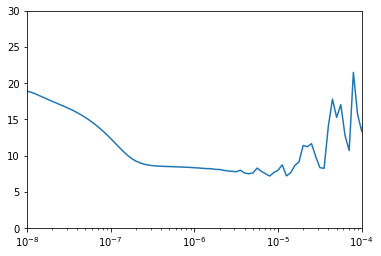

In [31]:
# Print the loss according to the learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [32]:
# Same model with learning rate set
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    
    # Simple RNN
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    
    # LSTM * 2
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # LSTM * 3
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 4s 474ms/step - loss: 80.8704 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 1s 82ms/step - loss: 24.4966 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 1s 79ms/step - loss: 18.2014 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 1s 75ms/step - loss: 14.2669 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 1s 70ms/step - loss: 10.8969 - mae: 11.2668
Epoch 6/400
8/8 [==============================] - 1s 68ms/step - loss: 11.3607 - mae: 12.5614
Epoch 7/400
8/8 [==============================] - 1s 67ms/step - loss: 12.7226 - mae: 13.0969
Epoch 8/400
8/8 [==============================] - 1s 68ms/step - loss: 12.2323 - mae: 12.5061
Epoch 9/400
8/8 [==============================] - 1s 68ms/step - loss: 14.8454 - mae: 14.8549
Epoch 10/400
8/8 [==============================] - 1s 71ms/step - loss: 21.2960 - mae: 21.8020
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 1s 75ms/step - loss: 5.3103 - mae: 5.6857
Epoch 88/400
8/8 [==============================] - 1s 67ms/step - loss: 5.5698 - mae: 5.9648
Epoch 89/400
8/8 [==============================] - 1s 91ms/step - loss: 5.1624 - mae: 5.6689
Epoch 90/400
8/8 [==============================] - 1s 101ms/step - loss: 6.1466 - mae: 6.5924
Epoch 91/400
8/8 [==============================] - 1s 120ms/step - loss: 5.9763 - mae: 6.3768
Epoch 92/400
8/8 [==============================] - 1s 72ms/step - loss: 5.3772 - mae: 5.8612
Epoch 93/400
8/8 [==============================] - 1s 90ms/step - loss: 4.8528 - mae: 5.3389
Epoch 94/400
8/8 [==============================] - 1s 67ms/step - loss: 4.9829 - mae: 5.5392
Epoch 95/400
8/8 [==============================] - 1s 73ms/step - loss: 4.9339 - mae: 5.4513
Epoch 96/400
8/8 [==============================] - 1s 72ms/step - loss: 5.0090 - mae: 5.4503
Epoch 97/400
8/8 [==============================] - 1s 66ms/step - loss

8/8 [==============================] - 1s 84ms/step - loss: 4.3832 - mae: 4.9206
Epoch 174/400
8/8 [==============================] - 1s 69ms/step - loss: 4.7277 - mae: 5.1845
Epoch 175/400
8/8 [==============================] - 1s 67ms/step - loss: 4.8555 - mae: 5.2636
Epoch 176/400
8/8 [==============================] - 1s 80ms/step - loss: 4.7461 - mae: 5.1895
Epoch 177/400
8/8 [==============================] - 1s 76ms/step - loss: 4.5247 - mae: 4.9987
Epoch 178/400
8/8 [==============================] - 1s 72ms/step - loss: 4.4666 - mae: 4.8853
Epoch 179/400
8/8 [==============================] - 1s 69ms/step - loss: 4.6729 - mae: 5.1552
Epoch 180/400
8/8 [==============================] - 1s 69ms/step - loss: 5.2606 - mae: 5.7293
Epoch 181/400
8/8 [==============================] - 1s 72ms/step - loss: 5.3465 - mae: 5.7083
Epoch 182/400
8/8 [==============================] - 1s 76ms/step - loss: 4.4502 - mae: 4.9382
Epoch 183/400
8/8 [==============================] - 1s 77ms/ste

8/8 [==============================] - 1s 76ms/step - loss: 4.3599 - mae: 4.8110
Epoch 260/400
8/8 [==============================] - 1s 84ms/step - loss: 4.0755 - mae: 4.5975
Epoch 261/400
8/8 [==============================] - 1s 81ms/step - loss: 4.7706 - mae: 5.2241
Epoch 262/400
8/8 [==============================] - 1s 76ms/step - loss: 5.4458 - mae: 6.0077
Epoch 263/400
8/8 [==============================] - 1s 72ms/step - loss: 4.6388 - mae: 5.0301
Epoch 264/400
8/8 [==============================] - 1s 70ms/step - loss: 4.7670 - mae: 5.3162
Epoch 265/400
8/8 [==============================] - 1s 72ms/step - loss: 5.5275 - mae: 6.1705
Epoch 266/400
8/8 [==============================] - 1s 69ms/step - loss: 5.0575 - mae: 5.6905
Epoch 267/400
8/8 [==============================] - 1s 70ms/step - loss: 7.3979 - mae: 7.6422
Epoch 268/400
8/8 [==============================] - 1s 79ms/step - loss: 5.5868 - mae: 5.9922
Epoch 269/400
8/8 [==============================] - 1s 73ms/ste

8/8 [==============================] - 1s 75ms/step - loss: 4.6200 - mae: 5.1720
Epoch 346/400
8/8 [==============================] - 1s 73ms/step - loss: 5.3964 - mae: 5.9473
Epoch 347/400
8/8 [==============================] - 1s 84ms/step - loss: 4.7142 - mae: 5.3283
Epoch 348/400
8/8 [==============================] - 1s 85ms/step - loss: 5.1639 - mae: 5.7225
Epoch 349/400
8/8 [==============================] - 1s 91ms/step - loss: 5.3213 - mae: 5.9541
Epoch 350/400
8/8 [==============================] - 1s 91ms/step - loss: 4.8611 - mae: 5.3137
Epoch 351/400
8/8 [==============================] - 1s 97ms/step - loss: 4.0941 - mae: 4.6441
Epoch 352/400
8/8 [==============================] - 1s 97ms/step - loss: 4.3963 - mae: 4.8948
Epoch 353/400
8/8 [==============================] - 1s 102ms/step - loss: 4.2424 - mae: 4.7250
Epoch 354/400
8/8 [==============================] - 1s 99ms/step - loss: 4.1350 - mae: 4.6697
Epoch 355/400
8/8 [==============================] - 1s 74ms/st

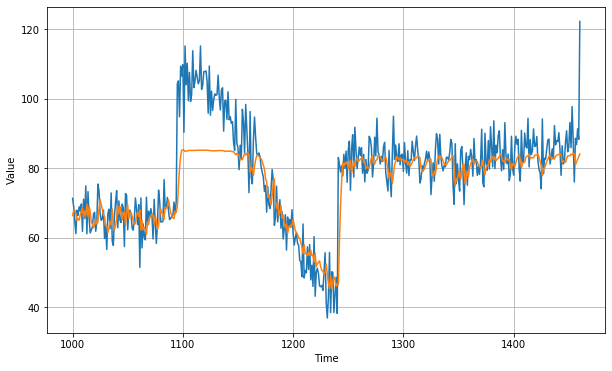

In [33]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.2463145

<Figure size 432x288 with 0 Axes>

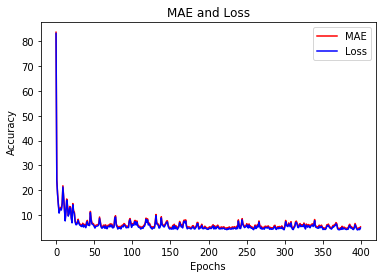

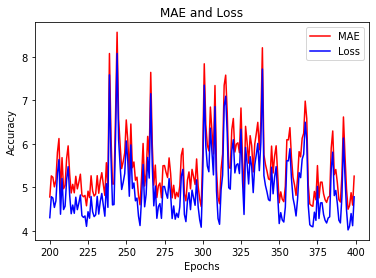

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()